In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
from sklearn.decomposition import PCA
import math
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.manifold import Isomap
from sklearn.decomposition import KernelPCA
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
from sklearn import mixture
from sklearn.manifold import TSNE, MDS
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import LocallyLinearEmbedding, trustworthiness
from sklearn.preprocessing import StandardScaler

### Functions

In [3]:
from scipy.sparse import csgraph, csc_matrix
import scipy.sparse.linalg as LA
import collections
from sklearn.neighbors import kneighbors_graph
import scipy


def mds_reduction(data, target_dimension):
  return pd.DataFrame(MDS(n_components=target_dimension,eps=1e-4,n_init=15).fit_transform(data))
#PCA get principal components Functions
def get_pca(x):
    pca = PCA(n_components = d)
    pca.fit_transform(x)
    # print(pca.explained_variance_ratio_)
    return pca.explained_variance_ratio_, pca.components_
#Identifying Components with small Eigenvalue
def find_normal_vectors(eigens, vectors, THRESHOLD=0.99):
  res = sum(eigens)
  current = 0
  normal_vectors = []
  for i in range(0,len(eigens)):
    current += eigens[i]
    if current/res > THRESHOLD:
      for j in range(i+1,len(eigens)):
        normal_vectors.append(vectors[j])
      break
  return normal_vectors

def get_reduced(X, target_dimension, reduction_type):
  X_transformed = []
  if reduction_type == 'iso':
    embedding = Isomap(n_components=target_dimension, n_neighbors=10)
    X_transformed = embedding.fit_transform(X)
  elif reduction_type == 'pca':
    transformer = PCA(n_components=target_dimension)
    X_transformed = transformer.fit_transform(X)
  elif reduction_type == 'k-pca':
    transformer = KernelPCA(n_components=target_dimension, kernel='rbf')
    X_transformed = transformer.fit_transform(X)
  elif reduction_type == 'tsne':
    X_transformed = TSNE(n_components=target_dimension, learning_rate='auto', init='pca').fit_transform(X)
  elif reduction_type == 'mds':
    X_transformed = mds_reduction(X,target_dimension)
  elif reduction_type == 'LLE':
    X_transformed = LocallyLinearEmbedding(n_components=target_dimension, n_neighbors=30).fit_transform(X)
  return X_transformed

def get_cluster(X, num_cluster, cluster_type):
  if cluster_type == 'GMM':
    model = mixture.GaussianMixture(n_components=num_cluster, covariance_type='full', n_init=100)
    model.fit(X)
    labels = model.predict(X)
  elif cluster_type == 'k-means':
    model=KMeans(n_clusters=num_cluster, n_init=10, max_iter=10000)
    model.fit(X)
    labels = model.predict(X)
  elif cluster_type == 'HS':
    model = AgglomerativeClustering(n_clusters=num_cluster, linkage='single')
    model.fit(X)
    labels = model.labels_
  elif cluster_type == 'H':
    model = AgglomerativeClustering(n_clusters=num_cluster)
    model.fit(X)
    labels = model.labels_
  elif cluster_type == 'spectral':
    model = SpectralClustering(assign_labels='discretize', n_clusters=num_cluster, random_state=77, n_init=1)
    model.fit(X)
    labels = model.labels_
  elif cluster_type == 'custom-scan':
    td = get_dim(X)
    res = pd.DataFrame(LocallyLinearEmbedding(
      n_components=td,
      n_neighbors=d // 2,
      max_iter=100000
    ).fit_transform(
      X
    ), columns=[i for i in range(td)])
    # visualize_4d(res)
    compo = ComponentScan(n_neighbor=50, step=50).fit(res)
    compo.predict()
    return compo.components_
  elif cluster_type == 'PCAH':
    tmp = pd.DataFrame(PCA(
      n_components=3,
    ).fit_transform(
      X
    ), columns=[i for i in range(3)])
    return get_cluster(tmp, num_cluster, 'GMM')
  elif cluster_type == 'custom':
    td = 2
    p = pd.DataFrame(LocallyLinearEmbedding(n_components=td, n_neighbors=d).fit_transform(StandardScaler().fit_transform(X)), columns=[j for j in range(td)])
    return get_cluster(p, cluster_type='GMM', num_cluster=num_cluster)
  elif cluster_type == 'custom3d':
    td = 3
    p = pd.DataFrame(LocallyLinearEmbedding(n_components=td, n_neighbors=d).fit_transform(StandardScaler().fit_transform(X)), columns=[j for j in range(td)])
    return get_cluster(p, cluster_type='GMM', num_cluster=num_cluster)
  elif cluster_type == 'custom50':
    td = 2
    p = pd.DataFrame(LocallyLinearEmbedding(n_components=td, n_neighbors=2 * d).fit_transform(StandardScaler().fit_transform(X)), columns=[j for j in range(td)])
    return get_cluster(p, cluster_type='GMM', num_cluster=num_cluster)
  return labels

def show_distance_graph(X):
  neigh = NearestNeighbors(n_neighbors=2)
  nbrs = neigh.fit(X)
  distances, indices = nbrs.kneighbors(X)
  # Plotting K-distance Graph
  distances = np.sort(distances, axis=0)
  distances = distances[:,1]
  print(distances[-700:])
  plt.figure(figsize=(10,5))
  plt.plot(distances)
  plt.title('K-distance Graph',fontsize=20)
  plt.xlabel('Data Points sorted by distance',fontsize=14)
  plt.ylabel('Epsilon',fontsize=14)
  plt.show()
  #Visualization in 4D

def visualize_4d(frame, hot=True):
  fig = plt.figure(figsize=(7, 7))
  ax = fig.add_subplot(111, projection='3d')
  x = np.array(frame.iloc[:,0])
  if len(frame.columns) > 1:
    y = np.array(frame.iloc[:,1])
  if len(frame.columns) > 2:
    z = np.array(frame.iloc[:,2])
  if len(frame.columns) == 1:
    img = ax.scatter(x, x, s=2)
  if len(frame.columns) == 2:
    img = ax.scatter(x, y, s=2)
  elif len(frame.columns) == 3:
    img = ax.scatter(x, y, z, s=2)
  else:
    c = np.array(frame.iloc[:,3])
    if hot:
      img = ax.scatter(x, y, z, c=c, cmap=plt.hot(), s=2)
    else:
      img = ax.scatter(x, y, z, c=c, cmap='viridis', s=2)
  plt.show()

def merge(X, col, val_list):
  def get_col(row):
    for ind in range(len(val_list)):
      if row[col] in val_list[ind]:
        return 100 + ind
    return row[col]
  X[col] = X.apply(get_col, axis=1)
  X[col] = LabelEncoder().fit_transform(X[col])
  X[col] -= 1
  return X

def get_local_intrinsic_dimension(data, n_neighbors=5):
  X = np.array(data)
  M = np.matrix(X)
  L = n_neighbors
  if not isinstance(L, (int, np.integer))  or L<0:
    return 'n_neighbors must be a positive integer!'
  neigh = NearestNeighbors(n_neighbors=L)
  nbrs = neigh.fit(X)
  distances, indices = nbrs.kneighbors()
  mean = [np.mean([M[indices[i][j]] for j in range(L)],axis=0) for i in range(len(X))]
  #Calculating the local covariance matrix for each point
  C = [1/L * sum([np.dot( (M[indices[i][j],:]-mean[i]).transpose() , (M[indices[i][j],:]-mean[i]) ) for j in range(L)]) for i in range(len(X))]

  #Intrinsic Dimension Estimation
  THRESHOLD = 0.05
  intrinsic_dimension = [0] * len(X)

  E = [sorted(LA.eigsh(C[i])[0], reverse=True) for i in range(len(X))]
  for i in range(len(X)):
    eigen_list = E[i]
    d = len(eigen_list)
    first_eigenvalue= eigen_list[0]
    for j in range(1,d):
      if eigen_list[j]/first_eigenvalue < THRESHOLD:
        intrinsic_dimension[i]=j
        break
    if intrinsic_dimension[i]==0:
      intrinsic_dimension[i]=d
  return np.array(intrinsic_dimension)

def is_manifold(data, n_neighbors=5, error=0.05, is_calculated=False):
  #Assuming data is consisted of submanifolds with DIFFERENT dimensions OR is just consisted of one manifold
  if not is_calculated:
    ID = get_local_intrinsic_dimension(data, n_neighbors=n_neighbors)
  else:
    ID = data['local_dim'].to_numpy()
  total = len(ID)
  # n_manifolds = max(ID)
  counter = collections.Counter(ID)
  print(counter)
  dimension = counter.most_common(1)[0][0]
  accuracy = counter[dimension]/total
  if accuracy > 1-error:
    # print(f'Accuracy: {accuracy}. Data resides on a {dimension}-dimensional manifold!')
    return True,accuracy
  # print(f'Accuracy: {accuracy} -> Inconclusive!')
  return False,accuracy

def show_silouette(X, model_list, plot=True):
  silouette = [silhouette_score(X, model_list[i].fit_predict(X)) for i in range(len(model_list))]
  if plot:
    plt.figure(figsize=(20,20))
    plt.plot(range(2, len(model_list)+2),silouette,'gs-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Curve')
    plt.show()
  return silouette.index(max(silouette))+2

def get_affinity_matrix(coordinates, n_neighbors):
  A = kneighbors_graph(coordinates, n_neighbors=n_neighbors, mode='connectivity', include_self=False).toarray()
  for i in range(len(A)):
    for j in range(len(A[0])):
      if A[i][j] == 1:
        A[j][i] = 1
  return A

def eigengap_heuristic(A, plot = True):
    L = csgraph.laplacian(A, normed=True)
    # print(L)
    # n_components = A.shape[0]
    # LM parameter : Eigenvalues with largest magnitude (eigs, eigsh), that is, largest eigenvalues in
    # the euclidean norm of complex numbers.
    eigenvalues = scipy.linalg.eigh(L, eigvals_only=True)
    print(eigenvalues[:10])
    # eigenvalues = np.negative(eigenvalues[::-1])
    # eigenvalues, eigenvectors = LA.einp.negative(L)g(L)
    if plot:
        plt.title('Largest eigen values of input matrix')
        plt.scatter(np.arange(len(eigenvalues))[:10], eigenvalues[:10])
        plt.grid()

    # Identify the optimal number of clusters as the index corresponding
    # to the larger gap between eigen values
    max_gap = 0
    gap_pre_index = 0
    for i in range(1, 6):
        gap = np.abs(eigenvalues[i] / eigenvalues[i - 1])
        if gap > max_gap:
            max_gap = gap
            gap_pre_index = i

    return gap_pre_index

def predict_n_clusters(data, plot=False, **kwargs):
  return eigengap_heuristic(get_affinity_matrix(data, n_neighbors=15), plot)

class ComponentScan:

  def __init__(self, n_neighbor=50, step=50, max_rep=2):
    self.neighbors = None
    self.points = None
    self.n_neighbor = n_neighbor
    self.step = step
    self.components_ = None
    self.max_rep = max_rep

  def fit(self, X):
    self.neighbors = []
    for i in range(self.max_rep):
      nbrs = NearestNeighbors(n_neighbors=self.n_neighbor + i * self.step, algorithm='brute').fit(X)
      self.neighbors.append(nbrs.kneighbors(X)[1])
    self.points = X.to_numpy()
    self.components_ = np.full((len(X)), -1)
    return self

  def predict(self):
    cnt = 0
    ind = 0
    c = -1
    rep = 0
    while True:
      while ind < len(self.points):
        if self.components_[ind] == -1:
          break
        ind += 1
      if ind == len(self.points):
        break
      stack = [ind]
      combo = []
      cnt = 0
      c += 1
      while len(stack) > 0:
        cnt += 1
        if cnt % 1000 == 0:
          print(f'{cnt} - {len(stack)}')
        v = stack.pop()
        self.components_[v] = c
        for u in self.neighbors[rep][v]:
          if self.components_[u] == -1:
            stack.append(u)
            combo.append(u)
            self.components_[u] = c
      if len(combo) < 100:
        rep += 1
        if rep == self.max_rep:
          rep = 0
        for c in combo:
          self.components_[c] = -1
      else:
        rep = 0
    return c + 1

def get_dim(X, threshold=0.95, max_d=15, print_scores=False):
  for td in range(1, max_d):
    res = pd.DataFrame(LocallyLinearEmbedding(n_components=td, n_neighbors=90, max_iter=1000).fit_transform(X),
                       columns=[i for i in range(td)])
    score = trustworthiness(X, res, n_neighbors=100)
    if print_scores:
      print(f'dim score {td}: {score}')
    if score >= threshold:
      return td
  return max_d

### Open Input

In [4]:
# Input
file = open('./R44.txt','r')
d, n, m, k, p = list(file.readline().split())
d, n, p, k = map(int, [d, n, p, k])
k_list = list(map(int, file.readline().split()))
ar = []
for i in range(n):
  ar.append(list(map(float, file.readline().split())))
df = pd.DataFrame(ar)
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
count,73941.000000,73941.000000,73941.000000,73941.000000,73941.000000,73941.000000,73941.000000,73941.000000,73941.000000,73941.000000,...,73941.000000,73941.000000,73941.000000,73941.000000,73941.000000,73941.000000,73941.000000,73941.000000,73941.000000,73941.000000
mean,941.444757,23.877039,24.520181,24.858390,38.659787,26.257202,29.706593,14.594661,13.526953,-22.208736,...,12.523568,22.886104,33.815922,-2.502605,29.667303,42.552214,19.536081,57.917733,24.297044,12.128779
std,510.223769,18.202808,18.947597,20.676379,19.955938,21.944339,19.667590,18.415769,19.575312,19.835295,...,20.758238,17.631568,17.326889,16.365223,16.178073,16.448045,14.917312,30.597096,18.837523,19.864675
min,-1190.150000,-90.520000,-89.220000,-93.660000,-92.270000,-100.520000,-91.560000,-97.870000,-111.550000,-118.310000,...,-89.690000,-82.680000,-77.300000,-80.230000,-82.150000,-88.060000,-84.890000,-106.480000,-85.990000,-91.580000
25%,580.130000,14.840000,15.900000,9.190000,26.130000,9.700000,16.550000,8.850000,6.980000,-32.820000,...,3.690000,14.010000,29.120000,-9.320000,23.650000,34.040000,13.260000,34.460000,14.420000,-1.870000
50%,935.070000,24.020000,23.560000,28.310000,40.900000,25.040000,29.500000,14.920000,14.160000,-21.670000,...,8.250000,25.580000,33.500000,-1.590000,28.850000,41.710000,18.710000,62.070000,24.220000,13.680000
75%,1373.050000,33.150000,34.470000,35.020000,51.450000,42.430000,40.560000,20.320000,20.310000,-9.990000,...,24.520000,29.620000,38.240000,5.030000,35.920000,54.120000,26.130000,78.970000,35.000000,24.760000
max,1763.440000,90.910000,103.820000,103.210000,115.090000,113.840000,135.300000,147.530000,136.740000,89.530000,...,127.860000,120.830000,132.510000,78.610000,106.010000,95.250000,84.640000,137.870000,88.060000,91.540000


[  45.70564407   45.73825204   45.79103078   45.82568821   45.86599176
   45.94971164   46.02917444   46.06348771   46.07210002   46.14533346
   46.14533346   46.22213106   46.32072322   46.44989989   46.49025919
   46.57262501   46.63695852   46.66383932   46.75359024   46.88864575
   46.95948573   46.96291622   46.98361204   46.99496888   47.00221591
   47.20080402   47.26980326   47.34838329   47.35400617   47.6183263
   47.65536066   47.69569373   47.73473997   47.78098157   47.95067883
   47.97607425   48.07827264   48.08986484   48.23665308   48.3150815
   48.35152635   48.46064073   48.47839828   48.55091657   48.71067645
   48.83464651   48.89145835   49.19312045   49.38762497   49.4445993
   49.7085898    49.74883818   49.838137     49.92073918   49.93299811
   50.12404114   50.53655805   50.60305228   50.78808719   50.89001965
   51.04304948   51.09195534   51.18026866   51.32871808   51.35772386
   51.48611075   51.55540418   51.94450597   52.18719287   52.31077805
   52.432

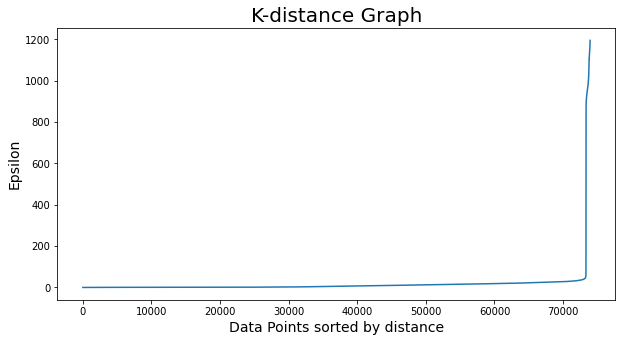

600


In [5]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(df[[i for i in range(d)]])
distances, indices = nbrs.kneighbors(df)
out = 0
show_distance_graph(df)
for i in range(n):
  if distances[i][1] > 100:
    df.at[i, 'manifold'] = -1
    out += 1
print(out)

### Finding Submanifolds

In [6]:
def find_best_eps(min_sample):
  tmp = df[df['manifold'] != -1].copy()
  l, r = 0, 200
  while (r - l) > 1:
    mid = (r + l) / 2
    print(mid)
    model_name = 'dbscan'
    model = DBSCAN(eps=mid, min_samples=min_sample)
    model.fit(tmp[[i for i in range(d)]])
    tmp['subset'] = model.labels_
    print(f"samples: {min_sample}")
    print(f"count: {len(tmp[tmp['subset'] == -1])}")
    print(f"cluster count: {tmp['subset'].max() + 1}")
    if len(tmp[tmp['subset'] == -1]) > 0:
      l = mid
    else:
      r = mid
  return r

In [7]:
#DBSCAN
# Finding the best epsilon for the least value of min sample results in maximum subsets such that it doesn't have any outlier
#best_eps = find_best_eps(2)
best_eps = 82.03125
model = DBSCAN(eps=best_eps, min_samples=2)
model.fit(df[df['manifold'] != -1][[i for i in range(d)]])
df.loc[df['manifold'] != -1, 'manifold'] = model.labels_

In [9]:
%matplotlib inline
multi = [8, 20, 22, 33]
if multi is None:
  multi = []
  for i in range(int(df['manifold'].max()) + 1):
    print(i)
    X = df[df['manifold'] == i][[i for i in range(d)]]
    if not is_manifold(X, n_neighbors=25)[0] and not is_manifold(X, n_neighbors=50)[0]:
      multi.append(i)
      td = 3
      res = pd.DataFrame(LocallyLinearEmbedding(n_components=td, n_neighbors=20, max_iter=10000).fit_transform(X),
                           columns=[i for i in range(td)])
      visualize_4d(res)
      visualize_4d(X)


print(multi)

[8, 20, 22, 33]


processing subset 8
dim: 3
LLE done
1000 - 993
1000 - 804
1000 - 817
manifold count: 3
0.0    1992
2.0    1816
1.0    1803
Name: sub1, dtype: int64


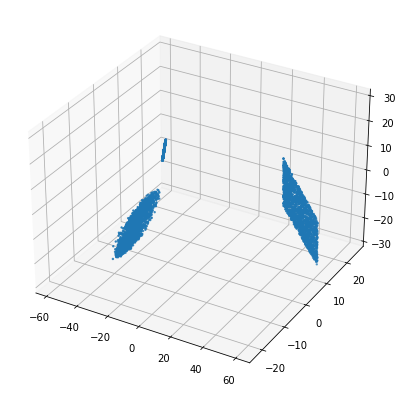

processing subset 20
dim: 3
LLE done
1000 - 861
1000 - 122
manifold count: 3
0.0    1860
2.0    1121
1.0     842
Name: sub1, dtype: int64


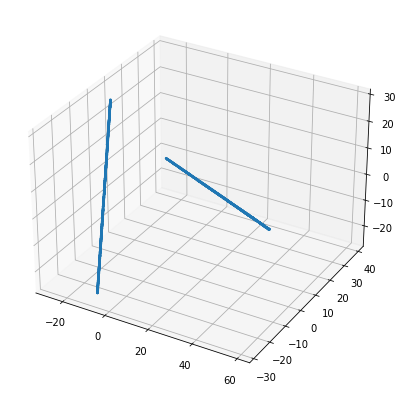

processing subset 22
dim: 3
LLE done
1000 - 594
1000 - 87
manifold count: 2
1.0    1656
0.0    1593
Name: sub1, dtype: int64


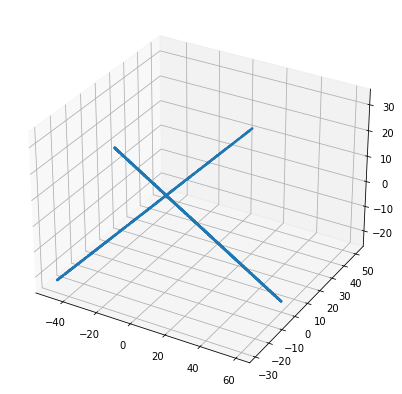

processing subset 33
dim: 3
LLE done
1000 - 417
2000 - 179
1000 - 706
manifold count: 2
0.0    2178
1.0    1705
Name: sub1, dtype: int64


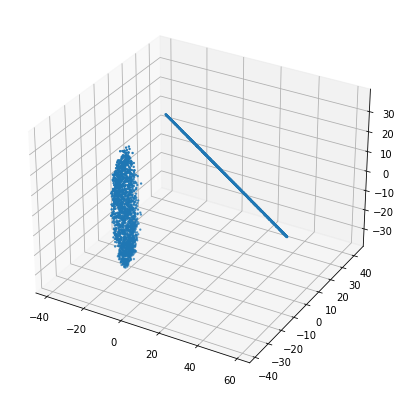

In [10]:
%matplotlib inline
sp = df.copy()
for subset in multi:
  print(f'processing subset {subset}')
  tmp = df[df['manifold'] == subset][[i for i in range(d)]]
  td = 3
  print(f'dim: {td}')
  res = pd.DataFrame(LocallyLinearEmbedding(
    n_components=td,
    n_neighbors=20,
    max_iter=1000
  ).fit_transform(
    tmp
  ), columns=[i for i in range(td)])
  # visualize_4d(res)
  print(f'LLE done')
  compo = ComponentScan(n_neighbor=50, step=50).fit(res)
  k = compo.predict()
  print(f'manifold count: {k}')
  if k > 10:
    continue
  sp.loc[sp['manifold'] == subset, 'sub1'] = compo.components_
  print(sp.loc[sp['manifold'] == subset, 'sub1'].value_counts())
  visualize_4d(pd.DataFrame(get_reduced(tmp, 3, 'pca'), columns=[j for j in range(3)]), hot=False)
if len(multi) > 0:
  sp['manifold'] = sp.manifold.astype(str) + '-' + sp.sub1.astype(str)
  sp = sp.drop(['sub1'], axis=1)
  sp['manifold'] = LabelEncoder().fit_transform(sp['manifold'])
  sp['manifold'] -= 1
  sp['manifold'].describe()

In [ ]:
# Custom cluster for manifold
final_k_list = []
cluster_type = []
for i in range(int(sp.manifold.max()) + 1):
  print(i)
  if i in [14]:  # Manually by visualization
    cluster_type.append('PCAH')
    final_k_list.append(3)
    continue
  X = sp[sp['manifold'] == i][[j for j in range(d)]]
  td = max(get_dim(X, max_d=7), 3)
  res = pd.DataFrame(LocallyLinearEmbedding(
    n_components=td,
    n_neighbors=50,
    max_iter=1000
  ).fit_transform(
    X
  ), columns=[i for i in range(td)])
  k = ComponentScan(n_neighbor=50, step=50).fit(res).predict()
  if k < 10:
    cluster_type.append('custom-scan')
  else:
    cluster_type.append('HS')
  final_k_list.append(k if k < 10 else 1)

In [ ]:
%matplotlib inline
for i in range(int(sp['manifold'].max()) + 1):
    print(i)
    print(f'clusters: {final_k_list[i]}')
    X = sp[sp['manifold'] == i][[i for i in range(d)]]
    td = 3
    res = pd.DataFrame(LocallyLinearEmbedding(n_components=td, n_neighbors=20, max_iter=10000).fit_transform(X),
                         columns=[i for i in range(td)])
    res2 = pd.DataFrame(PCA(n_components=td).fit_transform(X),
                         columns=[i for i in range(td)])
    visualize_4d(res)
    visualize_4d(res2)

In [ ]:
%matplotlib notebook
df = sp
final_k_list = [1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 3, 1, 1, 1, 1, 1, 2, 1, 1, 4, 2]  # Calculated in last sections
final_k_list[16] = 3
cluster_type[16] = 'PCAH'
final_k_list[3] = 4
cluster_type[3] = 'custom'
final_k_list[24] = 2
cluster_type[24] = 'custom'
final_k_list[29] = 3
cluster_type[29] = 'custom'
cluster_type = ['custom'] * 56
print(final_k_list)
print(cluster_type)
xsum = 0
for c in final_k_list:
  xsum += c
print(xsum)

In [ ]:
%matplotlib inline
def most_common_dimension(data, n_neighbors=5):
  ID = get_local_intrinsic_dimension(data, n_neighbors=n_neighbors)
  total = len(ID)
  # n_manifolds = max(ID)
  counter = collections.Counter(ID)
  dimension = counter.most_common(1)[0][0]
  return dimension,counter[dimension]/total

def estimate_intrinsic_dimension(data,n_neighbors=5, method='most_common'):
  res = 0
  if method=='most_common':
    return most_common_dimension(data,n_neighbors)[0]
  if method=='average':
    return np.around(np.mean(get_local_intrinsic_dimension(data),axis=0),0).astype(int)

plt.close('all')
D = []
for i in range(int(df.manifold.max()) + 1):
  print(i)
  X = df[df['manifold'] == i][[j for j in range(d)]]
  dim1 = get_dim(X, max_d=6, print_scores=True)
  if dim1 < d:
    D.append(dim1)
  else:
    D.append(estimate_intrinsic_dimension(X, n_neighbors=2 * d))
  print(D[-1])
print(D)
# [1, 2, 6, 4, 6, 6, 1, 3, 6, 6, 3, 5, 2, 2, 5, 2, 4, 2, 4, 3, 1, 3, 3, 3, 3, 1, 1, 1, 6, 6, 3, 3, 2, 6]

In [ ]:
# Joining the cluster labeling
def join_clusters():
  df['cluster'] = [0]*n
  data_index = [0] * (int(df.manifold.max()) + 1)
  for i in range(n):
    index_manifold = int(df.at[i,'manifold'])
    if index_manifold!=-1:
      df.at[i,'cluster'] = list_labels[index_manifold][data_index[index_manifold]]
      data_index[index_manifold]+=1

list_labels = []
for i in range(int(df.manifold.max()) + 1):
  print(i)
  if final_k_list[i] == 1:
    list_labels.append([0] * len(df[df['manifold'] == i]))
    continue
  labels = get_cluster(df[df['manifold'] == i][[i for i in range(d)]], num_cluster=final_k_list[i], cluster_type=cluster_type[i])
  list_labels.append(labels)
print('------')
print(int(df.manifold.max()) + 1)
print('-------')
join_clusters()

### Output

In [ ]:
import miniball

THRESHOLD = 0.99
def find_normal_vectors(eigens,vectors):
  res = sum(eigens)
  current = 0
  normal_vectors = []
  for i in range(0,len(eigens)):
    current += eigens[i]
    if current/res > THRESHOLD:
      for j in range(i+1,len(eigens)):
        normal_vectors.append(vectors[j])
      break
  return normal_vectors
# Outputting
def get_affine_space(points):
  X = points
  s, v = get_pca(X)
  #Finding Normal Vectors using PCA
  A = find_normal_vectors(s, v)
  #Finding b-s using PCA
  b = []
  mean = np.mean(points, axis = 0)
  for j in range(len(A)):
    b.append(np.dot(A[j],mean))
  return A, b
def get_optimal_miniball(points):
  points = np.asarray(points)
  minlist = [min(points, key=lambda p: p[j])[j] for j in range(0,d)]
  points = [[p[j]-minlist[j] for j in range(0,d)] for p in points]
  mb = miniball.Miniball(points)
  c = mb.center()
  for j in range(0,d):
    c[j]+=minlist[j]
  r = math.sqrt(mb.squared_radius())
  if not mb.is_valid():
    print('Possibly invalid!')
  print('Relative error', mb.relative_error())
  return c,r
def spherical_measure(data):
  X = np.array(data)
  n = len(X)
  d = len(X[0])
  c,r = get_optimal_miniball(X)
  c = np.array(c)
  r = np.array(r)
  SSE = np.array([(np.linalg.norm(X[i]-c)-r)**2 for i in range(n)]).sum()
  total = n * (r**2)
  print(f'error divided by total: {SSE / total}')
  print(f'error: {SSE / n}')
  return SSE/total
def get_manifold_type(data, mcl_d, acceptable_error=1e-3):
  X = data.to_numpy()
  pca_d = d-len(find_normal_vectors(get_pca(X)[0], get_pca(X)[1]))
  if spherical_measure(data) < acceptable_error:
    print(f'{pca_d} - {mcl_d}')
    return 'Sphere'
  if pca_d > mcl_d:
    return 'Complex'
  return 'Affine'

vectors = [[[] for j in range(0,final_k_list[i])] for i in range(int(df.manifold.max()) + 1)]
#df.loc[df['column_name'] == some_value]
outlier = []
for i in range(n):
  if int(df.at[i, 'manifold']) == -1:
    outlier.append(i + 1)
  else:
    vectors[int(df.at[i, 'manifold'])][int(df.at[i, 'cluster'])].append(i + 1)

with open('./output.txt', 'w') as f:
  print(f'{n} {int(df.manifold.max()) + 1}', file=f)
  for i in range(int(df.manifold.max()) + 1):
    print(i)
    X = df[df['manifold'] == i][[j for j in range(d)]]
    if i >= len(D):
      D.append(10)
    manifold_type = get_manifold_type(X, D[i])
    if manifold_type == 'Complex':
      dimension = D[i]
    else:
      dimension = d - len(find_normal_vectors(get_pca(X)[0], get_pca(X)[1]))
    print(f'{dimension} ' + str(final_k_list[i]) + f' {manifold_type}', file=f)
    if manifold_type != 'Complex':
      A, B = get_affine_space(X)
      for j in range(len(A)):
        print(' '.join(list(map(str,A[j]))), file=f)
      print(' '.join(list(map(str,B))), file=f)
    if manifold_type == 'Sphere':
      c, r = get_optimal_miniball(X)
      print(' '.join(list(map(str, c))) + ' ' + str(r), file=f)
    for j in range(0,final_k_list[i]):
      print(str(len(vectors[i][j])) + ' ' + ' '.join(list(map(str, vectors[i][j]))), file=f)
  print(str(len(outlier)) + ' ' + ' '.join(list(map(str, outlier))), file=f)